# TBrain Esunbank Suspicious Activity Report

## Import Package

In [1]:
import os
import math
import random
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.

In [3]:
# Transform day_of_year through winter solstice and summer solstice.
def transform_day_of_year(day_of_year):
    if(day_of_year > 356):
        return (day_of_year-356)/((173+366)-356)
    elif(day_of_year < 173):
        return (day_of_year+366-356)/((173+366)-356)
    else:
        return 1-((day_of_year-173)/(356-173))

In [4]:
# Processing of data provided by the organizer 
def data_merge(alert, answer, custinfo):
    data = pd.merge(alert, answer, on='alert_key', how='left')
    data = pd.merge(data, custinfo, on='alert_key', how='left')
    return data

## Const & Inputs

Here are all of the parameters to change for the run.

In [84]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

## Data Preprocessing: Load Data

Processing of data provided by the organizer.

In [85]:
custinfo = pd.read_csv(os.path.join(path, 'data/train/public_train_x_custinfo_full_hashed.csv'))
custinfo.describe()

,alert_key,risk_rank,occupation_code,total_asset,AGE
count,25751.000000,25751.000000,25635.000000,2.575100e+04,25751.000000
mean,265685.626927,1.610578,14.251063,7.137427e+05,3.633024
std,58623.840868,0.906222,4.690025,2.435461e+06,1.309948
min,171142.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,212536.000000,1.000000,12.000000,7.508000e+03,3.000000
50%,266346.000000,1.000000,15.000000,1.288800e+05,3.000000
75%,316658.500000,3.000000,19.000000,5.972315e+05,4.000000
max,365073.000000,3.000000,20.000000,7.386321e+07,10.000000


In [86]:
custinfo.groupby('cust_id').count().describe()

,alert_key,risk_rank,occupation_code,total_asset,AGE
count,7708.000000,7708.000000,7708.000000,7708.000000,7708.000000
mean,3.340815,3.340815,3.325765,3.340815,3.340815
std,9.790127,9.790127,9.789102,9.790127,9.790127
min,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000
max,246.000000,246.000000,246.000000,246.000000,246.000000


In [87]:
remit = pd.read_csv(os.path.join(path, 'data/train/public_train_x_remit1_full_hashed.csv'))
remit.describe()

,trans_date,trans_no,trade_amount_usd
count,17167.000000,17167.000000,1.716700e+04
mean,219.783538,0.618862,6.132012e+04
std,106.080510,1.288764,7.857464e+04
min,0.000000,0.000000,0.000000e+00
25%,140.000000,0.000000,1.268600e+04
50%,236.000000,0.000000,3.719200e+04
75%,302.000000,1.000000,7.527400e+04
max,393.000000,4.000000,2.284801e+06


In [88]:
remit.groupby('cust_id').count().describe()

,trans_date,trans_no,trade_amount_usd
count,1144.000000,1144.000000,1144.000000
mean,15.006119,15.006119,15.006119
std,33.509677,33.509677,33.509677
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000
75%,14.000000,14.000000,14.000000
max,432.000000,432.000000,432.000000


In [140]:
train_alert = pd.read_csv(os.path.join(path, 'data/train/train_x_alert_date.csv'))
train_alert.describe()

,alert_key,date
count,23906.000000,23906.000000
mean,258505.143479,184.111813
std,54601.952904,110.927130
min,171142.000000,0.000000
25%,208550.750000,84.000000
50%,259224.500000,195.000000
75%,305789.000000,279.000000
max,352132.000000,364.000000


In [160]:
public_train_x_dp_full_hashed = pd.read_csv(os.path.join(path, 'data/train/public_train_x_dp_full_hashed.csv'))

In [161]:
public_train_x_dp_full_hashed_1 = public_train_x_dp_full_hashed.iloc[:len(public_train_x_dp_full_hashed)//2]

In [165]:
public_train_x_dp_full_hashed_1.to_csv(os.path.join(path, 'data/train/public_train_x_dp_full_hashed_1.csv'), index=False)

In [166]:
public_train_x_dp_full_hashed_2.to_csv(os.path.join(path, 'data/train/public_train_x_dp_full_hashed_2.csv'), index=False)

In [162]:
public_train_x_dp_full_hashed_2 = public_train_x_dp_full_hashed.iloc[len(public_train_x_dp_full_hashed)//2:]

In [156]:
breakpoint = train_alert.iloc[len(train_alert)//2]['date']
breakpoint

195

In [157]:
train = train_alert[train_alert['date'] < breakpoint]
valid = train_alert[train_alert['date'] >= breakpoint]

In [158]:
train.tail()

,alert_key,date
11893,258481,194
11894,258462,194
11895,258255,194
11896,258068,194
11897,258444,194


In [159]:
valid.head()

,alert_key,date
11898,259372,195
11899,259074,195
11900,259056,195
11901,258898,195
11902,258926,195


In [90]:
train_y_answer = pd.read_csv(os.path.join(path, 'data/train/train_y_answer.csv'))
train_y_answer.describe()

,alert_key,sar_flag
count,23906.000000,23906.000000
mean,258505.143479,0.009788
std,54601.952904,0.098453
min,171142.000000,0.000000
25%,208550.750000,0.000000
50%,259224.500000,0.000000
75%,305789.000000,0.000000
max,352132.000000,1.000000


In [91]:
public_alert = pd.read_csv(os.path.join(path, 'data/train/public_x_alert_date.csv'))
public_alert.describe()

,alert_key,date
count,1845.000000,1845.000000
mean,358724.454743,380.241192
std,3561.987663,7.769164
min,352249.000000,365.000000
25%,355759.000000,375.000000
50%,358472.000000,378.000000
75%,361594.000000,386.000000
max,365073.000000,393.000000


In [92]:
train = data_merge(train_alert, train_y_answer, custinfo)
train

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,171189,0,0,972ee157e63316e8a50dd489bc93730a3ee8a8959d5c6b...,1,17.0,375576.0,4
1,171202,0,0,a10ab33f90926fb18d7bb5e78034d7f04a1fbed95b7951...,3,12.0,2717416.0,2
2,171599,0,0,3433ecc068ed1c9e2f5037cab5d42d7b901e9bd624c1fb...,1,12.0,326517.0,4
3,171737,0,0,a0861608615a9365d90f4ba0a813c0ea0471987f925c8b...,3,14.0,1014759.0,4
4,171142,0,0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3
...,...,...,...,...,...,...,...,...
23901,352132,364,0,c49b33d1fde790ec03584672903f296e486615adfdc989...,1,19.0,3218731.0,3
23902,352125,364,0,0c2dc5fedc3689abf5ff4be14fe8fea8d23d22068297c2...,3,19.0,928963.0,3
23903,352080,364,0,1a93961c8fa830a1f32f5316b44f4964d65397f0311b11...,2,9.0,69080.0,6
23904,352075,364,0,9586b80d3ad1d74c0a1efe792cae2ecd073243fb01ed33...,3,3.0,262604.0,6


In [131]:
a = train[train['date']<195]
b = train[train['date']>=195]

In [93]:
public_y_answer = pd.DataFrame({'alert_key': public_alert['alert_key'], 'sar_flag': [np.nan]*len(public_alert)})
public = data_merge(public_alert, public_y_answer, custinfo)
public

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,352342,365,NaN,7629f010080267f680a4ca9c6cac71c4d4d86933dcc7ed...,1,17.0,506366.0,3
1,352866,365,NaN,e50deb3f2f87bf45e04940303f80c96929c836b0b03f54...,1,12.0,309830.0,4
2,352696,365,NaN,c6def618ad861703c025be4f41bdf7569310228ae93aef...,1,2.0,444392.0,3
3,352330,365,NaN,96d70b798f211393cfbcb83a8acd19f3e8c9c5c205960a...,1,19.0,143930.0,4
4,352683,365,NaN,40fa92acb89d1ebb319f0f200d31a5fcbdfcbd8ad432d7...,3,17.0,2112.0,2
...,...,...,...,...,...,...,...,...
1840,364472,393,NaN,bdda3ef79c5f052fd281c9f28f50a25977444eceaf9751...,3,19.0,2390889.0,4
1841,364788,393,NaN,0ef49d08b4af68e9cb2b2aa63198699ee7dc7b5e1c4550...,2,19.0,28681.0,2
1842,364673,393,NaN,f8ce663f765e2459578d285a032a16046fba0b2bba8e12...,1,19.0,213486.0,6
1843,364626,393,NaN,1729de666fbfd3bd42133e8226f5ade5709ef141d8e0b7...,1,19.0,2913.0,2


## Modelling & Predict

In [149]:
from util.metrics import recall_n, rmse 

In [95]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [96]:
def get_inputs(target_data):
    inputs = np.concatenate((
        target_data['risk_rank'].values,
        target_data['total_asset'].values,
        target_data['AGE'].values,
    ))
    return inputs

def get_outputs(target_data):
    outputs = target_data[['sar_flag']].values.mean(axis=0)
    return outputs

def get_batch_by_date(target_day, data, days=0):    
    history_days = pd.date_range(target_day - datetime.timedelta(days=days), target_day)
    target_data = data[data['Date'].eq(target_day)].reset_index(drop=True)
    history_data = data[data['Date'].isin(history_days.date)].reset_index(drop=True)
    x = get_inputs(target_data, history_data)
    y = get_outputs(target_data)
    return np.array(x), np.array(y)

def get_dataset_by_key_list(key_list, data, days=0):
    x_list, y_list = [], []
    for key in key_list:
        filted_data = data[data['alert_key'].eq(key)].reset_index(drop=True)
        x = get_inputs(filted_data)
        y = get_outputs(filted_data)
        x_list.append(x)
        y_list.append(y)
    return np.array(x_list), np.array(y_list)

In [97]:
# Split valid from train data
train_df, valid_df = train_test_split(train, test_size=0.2, shuffle=True, random_state=SEED)
train_df, valid_df = train_df.sort_values(by='date', ignore_index=True), valid_df.sort_values(by='date', ignore_index=True)
public_df = public.copy().sort_values(by='date', ignore_index=True)

# Get keys
train_keys, valid_keys = train_df['alert_key'].tolist(), valid_df['alert_key'].tolist()
public_keys = public_df['alert_key'].tolist()

# Build x, y for train and test data
train_x, train_y = get_dataset_by_key_list(train_keys, train, 1)
valid_x, valid_y = get_dataset_by_key_list(valid_keys, train, 1)
public_x, public_y = get_dataset_by_key_list(public_keys, public, 1)

print(train_x.shape, train_y.shape, valid_x.shape, public_x.shape)

(19124, 3) (19124, 1) (4782, 3) (1845, 3)


In [98]:
# Fit model   
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01, # 0.01
    colsample_bytree=0.7,
    seed=SEED,
    subsample=0.7,
    min_child_weight=1,
    max_depth=6, # 6
    reg_lambda=1, #1
    # reg_alpha=.1, #0
    n_estimators=1000
).fit(train_x, train_y.reshape(-1))

In [99]:
# Pred
train_df['probability'] = model.predict(train_x).reshape(-1, 1)
valid_df['probability'] = model.predict(valid_x).reshape(-1, 1)
public_df['probability'] = model.predict(public_x).reshape(-1, 1)

In [150]:
train_recall_n = recall_n(train_df['sar_flag'].tolist(), train_df['probability'].tolist())
print('train recall_n: ', round(train_recall_n, 5))

train recall_n:  0.01536


In [105]:
valid_recall_n = recall_n(valid_df['sar_flag'].tolist(), valid_df['probability'].tolist())
print('valid recall_n: ', round(valid_recall_n, 5))

valid recall_n:  0.00935


In [137]:
rmse(valid_df['sar_flag'].tolist(), valid_df['probability'].tolist())

0.08983400506800128

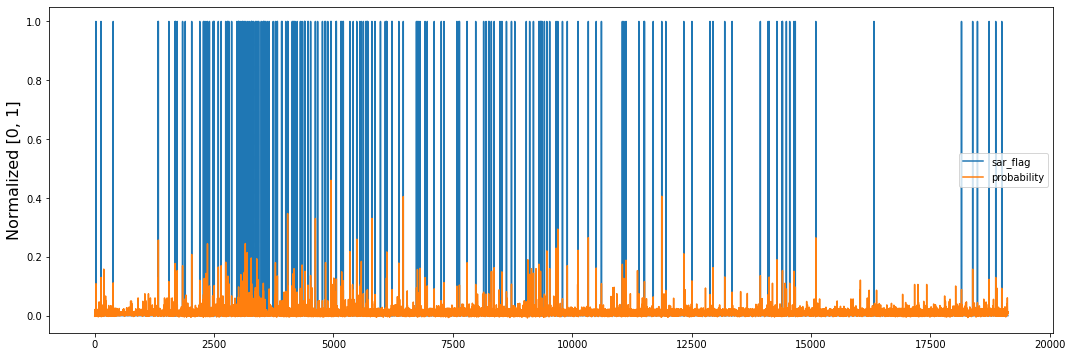

In [25]:
plt.figure(figsize=(18, 6))
# plt.suptitle('Probability Preview', fontsize=24, y=0.91)
    # plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]")
plt.plot(train_df['sar_flag'], label='sar_flag')
plt.plot(train_df['probability'], label='probability')
# plt.plot(train_df['date'], idf['Irradiance(kWd/m2)']/idf['Irradiance(kWd/m2)'].max(), label='Irradiance(kWd/m2)')
plt.ylabel('Normalized [0, 1]', fontsize=16)
plt.legend() 

## Submission

In [45]:
submission = pd.read_csv(os.path.join(path, 'submission/example.csv'))[['alert_key']]
submission = pd.merge(submission, public_df[['alert_key', 'probability']], on='alert_key', how='left')
submission.describe()

,alert_key,probability
count,3850.000000,1845.000000
mean,365303.605195,0.013953
std,7309.639174,0.018078
min,352249.000000,-0.005175
25%,358829.250000,0.004276
50%,365574.000000,0.011465
75%,371367.500000,0.016465
max,378428.000000,0.261824


In [51]:
submission['probability'] = submission['probability'].fillna(0)
submission['probability'] = submission['probability'].astype('float')
submission['probability'] = submission['probability'].apply(lambda x: 0 if x < 0 else x)

In [52]:
submission.describe()

,alert_key,probability
count,3850.000000,3850.000000
mean,365303.605195,0.006714
std,7309.639174,0.014309
min,352249.000000,0.000000
25%,358829.250000,0.000000
50%,365574.000000,0.000000
75%,371367.500000,0.011079
max,378428.000000,0.261824


In [53]:
submission.to_csv(os.path.join(path, f'submission/try-try-c.csv'), index=False)